**@author: James V. Talwar**

# Discovery Set: Quantifying MHC-I AI and Melanoma PRS SNP Effects in the TCGA

**About:** This notebook provides the code needed to generate Figure 2 panel D from the paper [*Autoimmune Alleles at the Major Histocompatibility Locus Modify Melanoma Susceptibility*](https://www.biorxiv.org/content/10.1101/2021.08.12.456166v1.full). These analyses quantified the effect size of AI MHC-I alleles in skin cutaneous melanoma (SKCM) cases in the TCGA. Melanoma PRS SNP effects were also generated and provide a context for AI MHC-I alleles effect in modulating melanoma risk.

## 1. Import Packages; Load Data

In [1]:
import pandas as pd 
import tqdm as tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from collections import defaultdict
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multitest import fdrcorrection

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
#get AI alleles
autoimmuneAlleles = set(pd.read_csv("../Data/AutoimmuneAlleles.tsv", sep = "\t", header = None)[0].tolist())
autoimmuneAlleles

{'HLA-B13:02',
 'HLA-B27:05',
 'HLA-B39:06',
 'HLA-B51:01',
 'HLA-B57:01',
 'HLA-C06:02',
 'HLA-C12:03'}

Load in protective and predisposing PRS SNP genotypes (as defined by the PRS by [Gu et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6240742/)) in SKCM TCGA: 

In [3]:
predisposingTCGASNPs = pd.read_csv("../GenotypeData/TCGAPredisposingMelanomaSNPs.tsv", sep = "\t", index_col = 0)
protectiveTCGASNPs = pd.read_csv("../GenotypeData/TCGAProtectiveMelanomaSNPs.tsv", sep = "\t", index_col = 0)

Load in TCGA summary dataframe (MHC-I genotypes, Age of Diagnosis, Sex, etc.):

In [4]:
tcgaSummary = pd.read_csv("../GenotypeData/TCGA_Summary_With_BRAFV600E_Mutation_Status.tsv", index_col = 0, sep = "\t")

#Ensure AI Allele Status is correct
tcgaSummary["HasProtection"] = [(len(set(row["A1":"C2"]).intersection(autoimmuneAlleles)) > 0) for i,row in tcgaSummary.iterrows()]

#Filter out individuals < 20 years old given increased likelihood of rare germline predisposing variants.
tcgaSummary = tcgaSummary[tcgaSummary.Age >= 20]

Concatenate TCGA summary with SNP their genotypes:

In [5]:
tcgaWithSNPs = tcgaSummary[tcgaSummary.index.isin(protectiveTCGASNPs.index)]
tcgaWithSNPs = pd.merge(pd.merge(tcgaWithSNPs, protectiveTCGASNPs,left_index = True, right_index = True), predisposingTCGASNPs, left_index= True, right_index = True)

Load in PRS SNP effect csv with the corrected SNP locations (many are off by 1 as reported in the Gu Melanoma PRS paper):

In [6]:
prsDF = pd.read_csv("../Data/Gu_Melanoma_PRS/PRS_Weights.tsv", sep = "\t", index_col = 0)
prsDF.head()

,Chr,Loc,Close genes in Genome Browser,"Close genes reported in Law et al., 2015",Weight#,Ref allele for the weight,CorrectedLocs
rs17416005,1.0,10761758.0,CASZ1,NaN,-0.00930,A,10761759.0
rs4655048,1.0,22668770.0,RP11-415K20.1|AL591122.20,NaN,-0.00460,T,22668771.0
rs6679026,1.0,78619511.0,RNFT1P2|RP11-472F19.2|GIPC2,NaN,-0.01700,T,78619512.0
rs11577235,1.0,114113339.0,MTND5P20|RP11-473L1.1|MAGI3,NaN,-0.01400,T,114113340.0
rs491313,1.0,114639042.0,SYT6,NaN,0.00045,C,114639043.0


## 2. Data Processing, Formatting, and Statistical Analyses

Define a function to calculate Cliffs Delta (effect size) defined as:
 $$d = \frac{\left(COUNT(x1>x2) - COUNT(x2>x1)\right)}{n_1\cdot n_2} $$

In [7]:
#Input: 2 lists or numpy arrays of ints/floats
#Output: A Cliffs D effect size (bounded between -1 and 1). The direction of the effect is oriented to the first input
def CliffsD(x,y):
    d = 0
    for i in range(len(x)):
        for j in range(len(y)):
            if x[i] > y[j]:
                d += 1
            elif y[j] > x[i]:
                d -= 1
    
    return d/(len(x)*len(y))

**Calculate protective PRS SNPs age effects:**

In [8]:
protectiveSNPResults = defaultdict(lambda:defaultdict(float))

for snp in tqdm.tqdm(protectiveTCGASNPs.columns):
    hasSNP = tcgaWithSNPs[tcgaWithSNPs[snp] >= 1]["Age"]
    nope = tcgaWithSNPs[tcgaWithSNPs[snp] == 0]["Age"]
    if (len(hasSNP) == 0) or (len(nope) == 0):
        raise ValueError("SNP Issues: SNP {} is either completely missing or all indivduals all have at least 1.".format(snp))
        
    stat, pDisc = mannwhitneyu(hasSNP, nope)
    effectSize = CliffsD(hasSNP, nope) 
    medianAgeDiff = np.median(hasSNP) - np.median(nope)
    
    protectiveSNPResults[snp]["p"] = pDisc
    protectiveSNPResults[snp]["ageDiff"] = medianAgeDiff
    protectiveSNPResults[snp]["CliffsD"] = effectSize

100%|██████████| 86/86 [00:22<00:00,  3.86it/s]


In [9]:
(sorted(protectiveSNPResults.items(), key = lambda x: x[1]["p"]))[:5]

[('125073958',
  defaultdict(float,
              {'p': 0.015640644747458146,
               'ageDiff': 5.0,
               'CliffsD': 0.14347079037800686})),
 ('55977842',
  defaultdict(float,
              {'p': 0.0170305351524899,
               'ageDiff': 4.0,
               'CliffsD': 0.15556797020484173})),
 ('29745196',
  defaultdict(float,
              {'p': 0.019263284423085354,
               'ageDiff': -4.0,
               'CliffsD': -0.11495135688684076})),
 ('88870967',
  defaultdict(float,
              {'p': 0.020711007361642983,
               'ageDiff': 5.0,
               'CliffsD': 0.1675531914893617})),
 ('24110776',
  defaultdict(float,
              {'p': 0.02154905685305224,
               'ageDiff': 4.0,
               'CliffsD': 0.13109756097560976}))]

Correct MWU p-values (MH testing):

In [10]:
protectionCorrection = multipletests(pvals = [el[1]["p"] for el in sorted(protectiveSNPResults.items(), key = lambda x: x[1]["p"])], alpha = 0.05, method = "fdr_bh")
protectionCorrection

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False]),
 array([0.37064378, 0.37064378, 0.37064378, 0.37064378, 0.37064378,
        0.40890589, 0.40890589, 0.40890589, 0.40890589, 0.40890589,
        0.40890589, 0.41186168, 0.41186168, 0.41186168, 0.41186168,
        0.41186168, 0.41186168, 0.41186168, 0.41186168, 0.41186168,
        0.41186168, 0.41186168, 0.41186168, 

In [11]:
counter = 0
for el in sorted(protectiveSNPResults.items(), key = lambda x: x[1]["p"]):
    protectiveSNPResults[el[0]]["correctedP"] = protectionCorrection[1][counter]
    counter += 1

Sanity check:

In [12]:
print(len(sorted(protectiveSNPResults.items(), key = lambda x: x[1]["p"])))
sorted(protectiveSNPResults.items(), key = lambda x: x[1]["p"])[:5]

86


[('125073958',
  defaultdict(float,
              {'p': 0.015640644747458146,
               'ageDiff': 5.0,
               'CliffsD': 0.14347079037800686,
               'correctedP': 0.3706437778724985})),
 ('55977842',
  defaultdict(float,
              {'p': 0.0170305351524899,
               'ageDiff': 4.0,
               'CliffsD': 0.15556797020484173,
               'correctedP': 0.3706437778724985})),
 ('29745196',
  defaultdict(float,
              {'p': 0.019263284423085354,
               'ageDiff': -4.0,
               'CliffsD': -0.11495135688684076,
               'correctedP': 0.3706437778724985})),
 ('88870967',
  defaultdict(float,
              {'p': 0.020711007361642983,
               'ageDiff': 5.0,
               'CliffsD': 0.1675531914893617,
               'correctedP': 0.3706437778724985})),
 ('24110776',
  defaultdict(float,
              {'p': 0.02154905685305224,
               'ageDiff': 4.0,
               'CliffsD': 0.13109756097560976,
               'co

**Calculate predisposing PRS SNPs age effects:** 

In [13]:
#CliffsD/MWU Stratification
predisposingSNPResults = defaultdict(lambda:defaultdict(float))
for snp in tqdm.tqdm(predisposingTCGASNPs.columns):
    hasSNP = tcgaWithSNPs[tcgaWithSNPs[snp] >= 1]["Age"]
    nope = tcgaWithSNPs[tcgaWithSNPs[snp] == 0]["Age"]
    if (len(hasSNP) == 0) or (len(nope) == 0):
        raise ValueError("SNP Issues: SNP {} is either completely missing or all indivduals all have at least 1.".format(snp))
    
    stat, pDisc = mannwhitneyu(hasSNP, nope)
    effectSize = CliffsD(hasSNP, nope) 
    medianAgeDiff = np.median(hasSNP) - np.median(nope)
    
    predisposingSNPResults[snp]["p"] = pDisc
    predisposingSNPResults[snp]["ageDiff"] = medianAgeDiff
    predisposingSNPResults[snp]["CliffsD"] = effectSize

100%|██████████| 104/104 [00:28<00:00,  3.68it/s]


Correct MWU p-values (MH testing):

In [14]:
predisposingCorrection = multipletests(pvals = [el[1]["p"] for el in sorted(predisposingSNPResults.items(), key = lambda x: x[1]["p"])], alpha = 0.05, method = "fdr_bh")
predisposingCorrection

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False]),
 array([0.26931512, 0.30736184, 0.30736184, 0.34486091, 0.34768417,
        0.34768417, 0.34768417, 0.34768417, 0.34768417, 0.34768417,
        0.34768417, 0.34768417, 0.4100

In [15]:
counter = 0
for el in sorted(predisposingSNPResults.items(), key = lambda x: x[1]["p"]):
    predisposingSNPResults[el[0]]["correctedP"] = predisposingCorrection[1][counter]
    counter += 1

Sanity check:

In [16]:
print(len(sorted(predisposingSNPResults.items(), key = lambda x: x[1]["p"])))
sorted(predisposingSNPResults.items(), key = lambda x: x[1]["p"])[:5]

104


[('89846677',
  defaultdict(float,
              {'p': 0.002589568493729448,
               'ageDiff': -6.0,
               'CliffsD': -0.20308623960309355,
               'correctedP': 0.26931512334786256})),
 ('15691778',
  defaultdict(float,
              {'p': 0.00655955497741601,
               'ageDiff': -4.0,
               'CliffsD': -0.1503173394262503,
               'correctedP': 0.3073618429684449})),
 ('114639043',
  defaultdict(float,
              {'p': 0.008866207008705142,
               'ageDiff': -5.0,
               'CliffsD': -0.14369129220614368,
               'correctedP': 0.3073618429684449})),
 ('16984280',
  defaultdict(float,
              {'p': 0.013263881254015704,
               'ageDiff': 4.0,
               'CliffsD': 0.12782904099527154,
               'correctedP': 0.34486091260440827})),
 ('202176294',
  defaultdict(float,
              {'p': 0.024809426666393054,
               'ageDiff': -3.0,
               'CliffsD': -0.1090676338809473,
        

Map melanoma PRS weights to each SNP results dictionary:

In [17]:
allPRSSNPs = set(protectiveTCGASNPs.columns).union(set(predisposingTCGASNPs.columns)) #all TCGA PRS SNPs
allPRSSNPs = set([int(el) for el in allPRSSNPs])
print((allPRSSNPs))

{205357568, 15691778, 10904067, 163167746, 3554821, 95309317, 94597126, 149426184, 204484617, 64889360, 44058640, 30008848, 77204500, 55028246, 3353622, 55803929, 82163226, 102627353, 10761759, 21951009, 13067811, 125073958, 31675943, 108187689, 38571563, 29745196, 113924143, 31540784, 205163057, 162628146, 72922675, 21825075, 77255735, 75635255, 163843129, 17112633, 42988088, 88870967, 169481271, 121686078, 29185604, 108486215, 223656014, 28576341, 45534295, 1081434, 36302428, 89986144, 106856034, 114796132, 35583588, 10377318, 124396645, 30102135, 28718712, 33952378, 14938242, 7102597, 69657736, 166119571, 32268953, 89818265, 110504091, 130699420, 143003805, 22141595, 56316573, 23551652, 17099432, 6532778, 188112554, 246578346, 43207858, 73071282, 15011508, 142054581, 4126900, 24110776, 117847741, 114639043, 119572168, 73455308, 166413517, 5616334, 154605260, 16984280, 75239130, 89760474, 110698716, 109060830, 26548451, 44933349, 26252005, 244457, 105668843, 134457580, 219053292, 896

In [18]:
protectiveCounter = 0
predisposingCounter = 0  
howMany = 0 #sanity checker variables

for i,row in prsDF.iterrows():
    if row["CorrectedLocs"] not in allPRSSNPs: #TCGA has 190 of the 204 PRS SNPs
        howMany += 1
        continue
    
    if row["Weight#"] < 0:
        protectiveCounter += 1 
        protectiveSNPResults[str(int(row["CorrectedLocs"]))]["PRS_Weight"] = row["Weight#"]
        
    else: #PRS weight is greater than or == 0 so is a risk allele
        predisposingCounter += 1
        predisposingSNPResults[str(int(row["CorrectedLocs"]))]["PRS_Weight"] = row["Weight#"]
        
print("Added weights for {} protective PRS SNPs and {} predisposing PRS SNPs. {} PRS SNPs were not assigned (unable to be extracted from TCGA).".format(protectiveCounter, predisposingCounter, howMany))

Added weights for 86 protective PRS SNPs and 104 predisposing PRS SNPs. 14 PRS SNPs were not assigned (unable to be extracted from TCGA).


Get the top 5 protective and top 5 predisposing PRS weight SNPs:

In [19]:
topEffectSNPs = [el[0] for el in sorted(predisposingSNPResults.items(), key = lambda x: x[1]["PRS_Weight"], reverse = True)[:5]]
sorted(predisposingSNPResults.items(), key = lambda x: x[1]["PRS_Weight"], reverse = True)[:5]

[('89846677',
  defaultdict(float,
              {'p': 0.002589568493729448,
               'ageDiff': -6.0,
               'CliffsD': -0.20308623960309355,
               'correctedP': 0.26931512334786256,
               'PRS_Weight': 0.49})),
 ('89986144',
  defaultdict(float,
              {'p': 0.1166633440391519,
               'ageDiff': -2.0,
               'CliffsD': -0.08491161616161616,
               'correctedP': 0.44157988921735036,
               'PRS_Weight': 0.2})),
 ('32586748',
  defaultdict(float,
              {'p': 0.22345228829958963,
               'ageDiff': -0.5,
               'CliffsD': -0.05015015015015015,
               'correctedP': 0.44157988921735036,
               'PRS_Weight': 0.17})),
 ('89011046',
  defaultdict(float,
              {'p': 0.040117404516611624,
               'ageDiff': -2.5,
               'CliffsD': -0.09740259740259741,
               'correctedP': 0.3476841724773007,
               'PRS_Weight': 0.12})),
 ('1320247',
  defaultdic

In [20]:
topEffectSNPs = topEffectSNPs + [el[0] for el in sorted(protectiveSNPResults.items(), key = lambda x: x[1]["PRS_Weight"])[:5]]
sorted(protectiveSNPResults.items(), key = lambda x: x[1]["PRS_Weight"])[:5]

[('33952378',
  defaultdict(float,
              {'p': 0.05138241824957283,
               'ageDiff': 5.5,
               'CliffsD': 0.31787211740041926,
               'correctedP': 0.4089058863205999,
               'PRS_Weight': -0.4})),
 ('21825075',
  defaultdict(float,
              {'p': 0.2746284276000256,
               'ageDiff': -1.0,
               'CliffsD': 0.0385872369703572,
               'correctedP': 0.4118616840522085,
               'PRS_Weight': -0.14})),
 ('21889289',
  defaultdict(float,
              {'p': 0.4147308235210575,
               'ageDiff': -6.0,
               'CliffsD': -0.04219077568134172,
               'correctedP': 0.4630996002377695,
               'PRS_Weight': -0.13})),
 ('89753436',
  defaultdict(float,
              {'p': 0.28666683402411686,
               'ageDiff': 4.0,
               'CliffsD': 0.03740481267133719,
               'correctedP': 0.4138404837611497,
               'PRS_Weight': -0.11})),
 ('22679902',
  defaultdict(float

In [21]:
print("The top 10 PRS Weight SNPs are: {}".format(topEffectSNPs))

The top 10 PRS Weight SNPs are: ['89846677', '89986144', '32586748', '89011046', '1320247', '33952378', '21825075', '21889289', '89753436', '22679902']


Quantify MHC-I AI allele effect size:

In [22]:
aiCliffsD = CliffsD(list(tcgaWithSNPs[tcgaWithSNPs.HasProtection == 1].Age), list(tcgaWithSNPs[tcgaWithSNPs.HasProtection == 0].Age))
print("MHC-I AI Cliffs D: {0:.5f}".format(aiCliffsD))

MHC-I AI Cliffs D: 0.16514


Summarize top 5 protective and top 5 predisposing PRS weight SNPs with corresponding AI effect:

In [23]:
mapToPRSWeight = defaultdict(lambda: defaultdict(float))
for el in topEffectSNPs:
    #el = str(snp)
    if el in protectiveSNPResults:
        mapToPRSWeight[el]["Weight"] = protectiveSNPResults[el]["PRS_Weight"]
        mapToPRSWeight[el]["|Weight|"] = abs(protectiveSNPResults[el]["PRS_Weight"])
        mapToPRSWeight[el]["CliffsD"] = protectiveSNPResults[el]["CliffsD"]

    else:
        mapToPRSWeight[el]["Weight"] = predisposingSNPResults[el]["PRS_Weight"]
        mapToPRSWeight[el]["|Weight|"] = (predisposingSNPResults[el]["PRS_Weight"])
        mapToPRSWeight[el]["CliffsD"] = predisposingSNPResults[el]["CliffsD"]

Visualize top 10 PRS effect SNPs by weight magnitude with corresponding Cliffs D:

In [24]:
sortedTopWeights = sorted(mapToPRSWeight.items(), key = lambda x: x[1]["|Weight|"], reverse = True)
sortedTopWeights

[('89846677',
  defaultdict(float,
              {'Weight': 0.49,
               '|Weight|': 0.49,
               'CliffsD': -0.20308623960309355})),
 ('33952378',
  defaultdict(float,
              {'Weight': -0.4,
               '|Weight|': 0.4,
               'CliffsD': 0.31787211740041926})),
 ('89986144',
  defaultdict(float,
              {'Weight': 0.2,
               '|Weight|': 0.2,
               'CliffsD': -0.08491161616161616})),
 ('32586748',
  defaultdict(float,
              {'Weight': 0.17,
               '|Weight|': 0.17,
               'CliffsD': -0.05015015015015015})),
 ('21825075',
  defaultdict(float,
              {'Weight': -0.14,
               '|Weight|': 0.14,
               'CliffsD': 0.0385872369703572})),
 ('21889289',
  defaultdict(float,
              {'Weight': -0.13,
               '|Weight|': 0.13,
               'CliffsD': -0.04219077568134172})),
 ('89011046',
  defaultdict(float,
              {'Weight': 0.12,
               '|Weight|': 0.12,
     

## 3. Figure Generation

### Figure 2D: Cliffs D for MHC-I AI alleles and top 10 PRS weight SNPs

Reformulate the data from a dictionary to a dataframe for visualization and plotting:

In [25]:
mapToRSID = dict(zip(prsDF.CorrectedLocs, prsDF.index))

mapToPRSWeight["Has AI Allele"]["CliffsD"] = aiCliffsD

forPlottingEffectSize = pd.DataFrame(mapToPRSWeight).T
forPlottingEffectSize = forPlottingEffectSize.sort_values(by = ["CliffsD"], ascending = False)
forPlottingEffectSize["|CliffsD|"] = abs(forPlottingEffectSize.CliffsD)
forPlottingEffectSize.index = [mapToRSID.get(float(el + ".0")) if el != "Has AI Allele" else el for el in forPlottingEffectSize.index]
forPlottingEffectSize

,Weight,|Weight|,CliffsD,|CliffsD|
rs250417,-0.400,0.400,0.317872,0.317872
Has AI Allele,NaN,NaN,0.165143,0.165143
rs380286,0.082,0.082,0.053924,0.053924
rs7852450,-0.140,0.140,0.038587,0.038587
rs3794638,-0.110,0.110,0.037405,0.037405
rs75286671,-0.130,0.130,-0.042191,0.042191
rs6088372,0.170,0.170,-0.050150,0.050150
rs1805008,0.200,0.200,-0.084912,0.084912
rs1393350,0.120,0.120,-0.097403,0.097403
rs139791480,-0.110,0.110,-0.176648,0.176648


Plot Cliffs D effect size:

[Text(0, 0, 'rs250417: SLC45A2'),
 Text(1, 0, 'Has AI Allele: MHC-I'),
 Text(2, 0, 'rs380286: TERT'),
 Text(3, 0, 'rs7852450: CDKN2A'),
 Text(4, 0, 'rs3794638: CDK10'),
 Text(5, 0, 'rs75286671: KCNIP4'),
 Text(6, 0, 'rs6088372: ASIP'),
 Text(7, 0, 'rs1805008: MC1R'),
 Text(8, 0, 'rs1393350: TYR'),
 Text(9, 0, 'rs139791480: AL033539.18'),
 Text(10, 0, 'rs75570604: MC1R')]

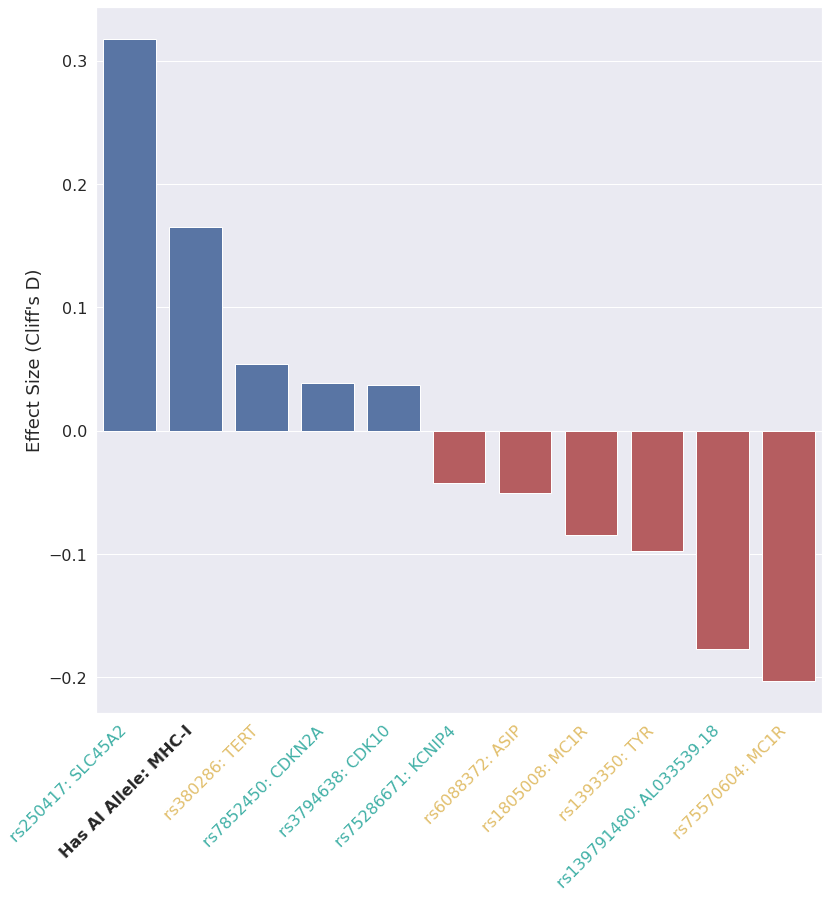

In [26]:
snpToGeneMapping = {"rs250417":"SLC45A2", "rs380286":"TERT", "rs7852450":"CDKN2A",
                   "rs3794638":"CDK10", "rs75286671":"KCNIP4","rs6088372":"ASIP",
                   "rs1805008":"MC1R", "rs1393350":"TYR", "rs139791480":"AL033539.18",
                   "rs75570604":"MC1R", "Has AI Allele":"MHC-I"}

sns.set(font_scale=1.1)
fig, ax = plt.subplots(figsize=(13, 13))
sns.barplot(data = forPlottingEffectSize, x = forPlottingEffectSize.index, y = "CliffsD", palette = ["r" if v < 0 else "b" for v in forPlottingEffectSize.CliffsD])
plt.ylabel("Effect Size (Cliff's D)", fontsize = 18)
plt.xticks(rotation = 45, fontsize = 16, ha = "right")
plt.yticks(fontsize = 16)


#plt.draw() #This is needed so the y-tick labels are populated...
newLabels = [item.get_text()+ ": " + snpToGeneMapping.get(item.get_text()) for item in ax.get_xticklabels()]
for i in range(len(ax.get_xticklabels())):
    xLabel = ax.get_xticklabels()[i].get_text().split("_")[0]
    if xLabel not in prsDF.index:
        ax.get_xticklabels()[i].set_fontweight("bold")
    elif str(int(prsDF.loc[xLabel, "CorrectedLocs"])) in predisposingSNPResults:
        ax.get_xticklabels()[i].set_color("#E1BE6A") #yellow
    elif str(int(prsDF.loc[xLabel, "CorrectedLocs"])) in protectiveSNPResults:
        ax.get_xticklabels()[i].set_color("#40B0A6") #turquoise 
        
ax.set_xticklabels(newLabels)

PRS SNP to risk factor(s): <br><br>
**rs250417** --> Suggested/Nearest Gene: *SLC45A2*; Postulated risk association: Pigmentation <br>
**rs380286** --> Suggested/Nearest Gene: *TERT/CLPTMIL*; Postulated risk association: Telomere Elongation <br> 
**rs7852450** --> Suggested/Nearest Gene: *CDKN2A/MTAP*; Postulated risk association: Cell Cycle Regulation <br>
**rs3794638** --> Suggested/Nearest Gene: *CDK10*; Postulated risk association: Cell Proliferation <br>
**rs75286671** --> Suggested/Nearest Gene: *KCNIP4* ; Function: Calcium ion binding, potassium channel regulator; Postulated risk association: ???<br>
**rs6088372** --> Suggested/Nearest Gene: *ASIP*; Postulated risk association: Pigmentation <br>
**rs1805008:** --> Suggested/Nearest Gene: *MC1R*; Postulated risk association: Pigmentation (Melanin synthesis and melanocyte proliferation) <br>
**rs1393350** --> Suggested/Nearest Gene: *TYR*; Postulated risk association: Pigmentation <br>
**rs139791480** --> Suggested/Nearest Gene: *AL033539.18/LOC105374972 (Intron Variant)*; Postulated risk association: ??? <br>
**rs75570604** --> Suggested/Nearest Gene: *MC1R*; Postulated risk association: Pigmentation (Melanin synthesis and melanocyte proliferation) <br>